# IERG 5350 Assignment 4: Advanced Algorithms for Continuous Control in RL

### Welcome to assignment 4 of our RL course!
*2020-2021 Term 1, IERG 5350: Reinforcement Learning. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao, SUN Hao, ZHAN Xiaohang.*


| Student Name | Student ID |
| :----: | :----: |
| Yingjie CAI | 1155139431 |

------


In this assignment, we will implement a system of RL that allows us to train and evaluate RL agents formally and efficiently.

In this notebook, you will go through the following components of the whole system:
- Preparation: Colab, and Environment
- Section 1: Training with algorithm PPO
- Section 2: Training with algorithm DDPG
- Section 3: Training with algorithm TD3
- Section 4: Transfer your PPO/ DDPG/ TD3 to another task: Four-Solution-Maze

The author of this assignment is SUN, Hao (sh018 AT ie.cuhk.edu.hk).

# Colab

### Introduction to Google Colab: 
From now on, our assignment as well as the final project will be based on the Google Colab, where you can apply for free GPU resources to accelerate the learning of your RL models. 

Here are some resources as intro to the Colab.

- YouTube Video: https://www.youtube.com/watch?v=inN8seMm7UI
- Colab Intro: https://colab.research.google.com/notebooks/intro.ipynb
(you may need to login with your google account)




# Gym Continuous Control Tasks

### Introduction to the Gym Continuous Control Envirionments

In the last assignment, you have already used the gym[atari] benchmarks, where the action space is discrete so that normal approach is value-based methods e.g., DQN.

In this assignment, we will try to implement three prevailing RL algorithms for continuous control tasks, namely the PPO(https://arxiv.org/abs/1707.06347), DDPG(https://arxiv.org/abs/1509.02971) and TD3(https://arxiv.org/abs/1802.09477).

We will now begin with a gym environment for continuous control,

The Pendulum-v0






In [ ]:
import gym
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
state = env.reset()
print('the state space is like', state)
print('the max and min action is: ',env.action_space.high,env.action_space.low)

'''so that you may need to use action value re-size if you want to use the tanh activation functions'''

the state space is like [-0.16154317  0.98686565 -0.98187255]
the max and min action is:  [2.] [-2.]


'so that you may need to use action value re-size if you want to use the tanh activation functions'

# PPO 

The Proximal Policy Optimization Algorithms is the most prevailing on-policy learning method. Although its sample efficiency is not as high as the off-policy methods, the PPO is relatively easy to implement and the learning is much more stable than off-policy methods. Whenever you have a task you want to try whether RL works, you may try to run a PPO agent at first. It is worth mentioning even the most challenging game, the StarCraftII agent AlphaStar is trained based on PPO (with lots of improvements, ofcourse).


## TODOs for You
The ppo has the benfitsof trust region policy optimization (TRPO) but is much simpler to implement, and with some implementation engeneering, the sample complexity of TRPO is further improved.

The key idea of PPO optimization is *Not Optimize the Policy Too Much in a Certain Step*, which follows the key insight of the method of TRPO.

In TRPO, the optimization objective of policy is to learn a policy such that 

$$\max_\theta \hat{\mathbb{E}}_t [\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$

subject to 

$$\hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(\cdot|s_t),\pi_\theta(\cdot|s_t)]] \le \delta$$

where $\hat{A}$ denotes the advantage function, rather than optimize the objective function of 

$$L^{PG}(\theta) = \hat{\mathbb{E}}_t[\log \pi_\theta(a_t|s_t)\hat{A}_t]$$

in the normal policy gradint methods.

The PPO proposed two alternative approaches to solve the constrained optimization above, namely the Clipped Surrogated Objective and the Adaptive KL penalty Coefficient. The former one is more generally used in practice as it's more convenient to implement, more efficient and owns stable performance.

The Clipped Surrogated Objective approach replace the surrogate objective

$$L^{CPI}(\theta) = \hat{\mathbb{E}}_t[\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}_t[r_t(\theta)\hat{A}_t]$$

of TRPO (CPI: Conservative Policy Iteration) by 

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[\min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

You can check that $L^{CLIP}(\theta) = L^{CPI}(\theta)$ around the old policy parameter $\theta_{old}$, i.e., when r = 1.

## TODOs here:

In this section, your task is to finish the code of a PPO algorithm and evaluate its performance in the Pendulum-v0 environment.

Specifically, you need to
- Q1. finish building up the ActorCritic ''\__init__'' function, i.e., build up the neural network.
- Q2. finish the foward function, in this part, there are two functions need to finish: the \_forward_actor function and the \_forward_critic function
- Q3. finish the select_action function, which is called during interacting with the environment, so that you may need to return an action as well as the (log-)probability of getting that action for future optimization
- Q4. finish the optimization steps for your PPO agent, that means you need to build up the surrogate loss through your saved tuples in previous episodes and optimize it with current network parameters.
- Q5. finally, you may need to optimize some of the hyper-parameters to have a better task performance. 

In [ ]:
# You need not to rivese this unless you want to try other hyper-parameter settings
# in which case you may revise the default values of class args()
from IPython import display
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
import random

Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
env = gym.make(ENV_NAME)
env.reset()

EPS = 1e-10 # you may need this tiny value somewhere, and think about why?
RESULT_DIR = 'Result_PPO'
mkdir(RESULT_DIR, exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/CheckPoints', exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/Rwds', exist_ok=True)
rwds = []
rwds_history = []

class args(object):
    repeat = 'repeat'
    hid_num = 256
    drop_prob = 0.1
    env_name = ENV_NAME
    seed = 1234
    num_episode = 1000
    batch_size = 5120
    max_step_per_round = 2000
    gamma = 0.995
    lamda = 0.97
    log_num_episode = 1
    num_epoch = 10
    minibatch_size = 256
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.01
    lr = 3e-4 # 3e-4
    num_parallel_run = 1
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = False
    advantage_norm = True
    lossvalue_norm = True

In [ ]:
 # You need not to rivese this, these classes are used for normalization
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

In [ ]:
# Here, you need to finish the first 5 tasks.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        '''
        Q1:
        Initialize your networks
        '''
        self.actor_fc1 = nn.Linear(num_inputs, 32)
        self.actor_fc2 = nn.Linear(32, args.hid_num)
        self.actor_fc3 = nn.Linear(args.hid_num, num_outputs)
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))

        self.critic_fc1 = nn.Linear(num_inputs, 64)
        self.critic_fc2 = nn.Linear(64, 64)
        self.critic_fc3 = nn.Linear(64, 1)

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)

    def forward(self, states):
        """
        Q2.1:
        run policy network (actor) as well as value network (critic)
        :param states: a tensor represents states
        :return: 3 Tensor2
        your _forward_actor() function should return both the mean value of action and the log-standard deviation of the action
        """

        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        '''
        Q2.2:
        build something like 
        x = activation (actor_fc(state))
        the logstd output has already been provided
        '''
        x = torch.tanh(self.actor_fc1(states))
        x = torch.tanh(self.actor_fc2(x))
        x = F.dropout(x, p=args.drop_prob, training=self.training)
        action_mean = torch.tanh(self.actor_fc3(x))
        action_logstd = self.actor_logstd.expand_as(action_mean)
        return action_mean, action_logstd

    def _forward_critic(self, states):
        '''
        Q2.3:
        build something like 
        x = activation (critic_fc(state))'''
        x = torch.tanh(self.critic_fc1(states))
        x = torch.tanh(self.critic_fc2(x))
        critic_value = self.critic_fc3(x)
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        Q3.1:
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        action_std = torch.exp(action_logstd)
        action = torch.normal(action_mean, action_std)
        if return_logproba:
            logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        '''
        Q3.2:
        given a mean and logstd of a gaussian,
        calculate the log-probability of a given x'''
        if std is None:
            std = torch.exp(logstd)

        std_sq = std.pow(2)
        logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)
        return logproba.sum(1)

    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        action_mean = action_mean.cpu()
        action_logstd = action_logstd.cpu()
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

env = gym.make(ENV_NAME)  
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
network.train()
def ppo(args):
    env = gym.make(args.env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    env.seed(args.seed)
    torch.manual_seed(args.seed)

    #network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)

    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:
            state = env.reset()
            if args.state_norm:
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                action, logproba = network.select_action(action_mean, action_logstd)
                action = action.cpu().data.numpy()[0]
                logproba = logproba.cpu().data.numpy()[0]
                next_state, reward, done, _ = env.step(action)

                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)

                if done:
                    break

                state = next_state

            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)
        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})
        rwds.extend(reward_list)
        batch = memory.sample()
        batch_size = len(memory)

        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        values = Tensor(batch.value)
        masks = Tensor(batch.mask)
        actions = Tensor(batch.action)
        states = Tensor(batch.state)
        oldlogproba = Tensor(batch.logproba)

        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        if args.advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
            minibatch_states = states[minibatch_ind]
            minibatch_actions = actions[minibatch_ind]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            minibatch_advantages = advantages[minibatch_ind]
            minibatch_returns = returns[minibatch_ind]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()



            '''
            Q4: 

            HERE: 
            now you have the advantages, and log-probabilities (both pi_new and pi_old)
            you need to do optimization according to the CLIP loss
            
            '''
            ratio =  torch.exp(minibatch_newlogproba - minibatch_oldlogproba)
            surr1 = ratio * minibatch_advantages
            surr2 = ratio.clamp(1 - clip_now, 1 + clip_now) * minibatch_advantages
            loss_surr = - torch.mean(torch.min(surr1, surr2))

            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(args.env_name)))

if __name__ == '__main__':
    for envname in [ENV_NAME]:
        args.env_name = envname
        test(args)

torch.save(network.state_dict(),args.env_name.split('-')[0]+'/CheckPoints/checkpoint_new_{0}hidden_{1}drop_prob_{2}repeat'.format(args.hid_num,args.drop_prob, args.repeat)) 
np.savetxt(args.env_name.split('-')[0]+'/Rwds/rwds_new_{0}hidden_{1}drop_prob_{2}repeat'.format(args.hid_num,args.drop_prob, args.repeat),rwds)

Finished episode: 0 Reward: -1273.5315 total_loss = 94.1264 = -0.0118 + 0.5 * 188.2829 + 0.01 * -0.3250
-----------------
Finished episode: 1 Reward: -1238.6181 total_loss = 84.9119 = -0.0165 + 0.5 * 169.8634 + 0.01 * -0.3302
-----------------
Finished episode: 2 Reward: -1147.4002 total_loss = 72.3506 = -0.0324 + 0.5 * 144.7723 + 0.01 * -0.3178
-----------------
Finished episode: 3 Reward: -1085.0436 total_loss = 66.1620 = -0.0064 + 0.5 * 132.3435 + 0.01 * -0.3316
-----------------
Finished episode: 4 Reward: -1186.3921 total_loss = 76.7583 = 0.0474 + 0.5 * 153.4285 + 0.01 * -0.3279
-----------------
Finished episode: 5 Reward: -1120.6595 total_loss = 73.5934 = 0.0769 + 0.5 * 147.0394 + 0.01 * -0.3231
-----------------
Finished episode: 6 Reward: -1102.4201 total_loss = 64.8228 = 0.0246 + 0.5 * 129.6029 + 0.01 * -0.3302
-----------------
Finished episode: 7 Reward: -1111.8241 total_loss = 72.1350 = 0.0751 + 0.5 * 144.1264 + 0.01 * -0.3276
-----------------
Finished episode: 8 Reward: 

# DDPG and TD3

The Deterministic Policy Gradient method was proposed by Silver et. al. 2014 (http://proceedings.mlr.press/v32/silver14.pdf), and DDPG is its deep version.

The DPG also uses the actor-critic paradigm, but maitains a deterministic version of policy. It optimizes the critic through the Bellman Equation, and optimize the actor through the chain rule. 

In this assignment, you may need to import some python files like DDPG.py and TD3.py to insert the method into training.
Here are some solutions from stackoverflow: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab.

It is easier to just copy it from Drive than upload it.
1. Store MYLIB.py in your Drive. (for this assignment, it will be the utils.py, DDPG.py and TD3.py)
2. Open the Colab.
3. Open the left side pane, select Files view (the file icon).
4. Click Mount Drive then Connect to Google Drive (the folder with google drive icon).
5. Copy it by running "! cp drive/My\ Drive/MYLIB.py . " in your Colab file code line.
6. import MYLIB




## TODOs for You (Please write down the answer in this block)

The TD3 is short for *Twin Delayed Deep Deterministic Policy Gradient*, their official open-source implementation is extremely clear and easy to follow! So I believe there is no need for you to build up the wheels one more time.

However, you really need to know about how this method works!
TD3 proposes several improvements based on the method of DDPG to improve its sample efficiency.

- Q6. In this part, your task is to read the paper, and read the code of the official implementation of TD3 and DDPG at:

https://github.com/sfujim/TD3/blob/master/DDPG.py

https://github.com/sfujim/TD3/blob/master/TD3.py

Then, please try to find the proposed improvements in TD3 over DDPG and summary them HERE:

1. clipped double-Q learning: 
 TD3 learns two Q-functions instead of one (hence "twin"), and uses the smaller of the two Q-values to form the targets in the Bellman error loss functions.
    - code: see the below block

In [ ]:
class Critic(nn.Module):
 def __init__(self, state_dim, action_dim):
  super(Critic, self).__init__()

  # Q1 architecture
  self.l1 = nn.Linear(state_dim + action_dim, 256)
  self.l2 = nn.Linear(256, 256)
  self.l3 = nn.Linear(256, 1)

  # Q2 architecture
  self.l4 = nn.Linear(state_dim + action_dim, 256)
  self.l5 = nn.Linear(256, 256)
  self.l6 = nn.Linear(256, 1)


 def forward(self, state, action):
  sa = torch.cat([state, action], 1)

  q1 = F.relu(self.l1(sa))
  q1 = F.relu(self.l2(q1))
  q1 = self.l3(q1)

  q2 = F.relu(self.l4(sa))
  q2 = F.relu(self.l5(q2))
  q2 = self.l6(q2)
  return q1, q2

self.critic = Critic(state_dim, action_dim).to(device)
self.critic_target = copy.deepcopy(self.critic)
 # Compute the target Q value
target_Q1, target_Q2 = self.critic_target(next_state, next_action)
target_Q = torch.min(target_Q1, target_Q2)
target_Q = reward + not_done * self.discount * target_Q

NameError: ignored

2. "Delayed" Policy updates
 TD3 updates the policy (and target networks) less frequently than the Q-function.
    - code: see the below block

In [ ]:
    # Delayed policy updates
if self.total_it % self.policy_freq == 0:

      # Compute actor loss
    actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
      
      # Optimize the actor 
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

      # Update the frozen target models
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

3. Target Policy Smoothing. 
 TD3 adds noise to the target action, to make it harder for the policy to exploit Q-function errors by smoothing out Q along changes in action.
    - code: see the below block

In [ ]:
# Select action according to policy and add clipped noise
noise = (
        torch.randn_like(action) * self.policy_noise
      ).clamp(-self.noise_clip, self.noise_clip)
      
next_action = (
        self.actor_target(next_state) + noise
      ).clamp(-self.max_action, self.max_action)

4. Critic Structure (TD3/OursDDPG/DDPG)
    - code: see the code below


In [ ]:
class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		self.l1 = nn.Linear(state_dim, 400)
		self.l2 = nn.Linear(400 + action_dim, 300)
		self.l3 = nn.Linear(300, 1)

class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		self.l1 = nn.Linear(state_dim + action_dim, 400)
		self.l2 = nn.Linear(400, 300)
		self.l3 = nn.Linear(300, 1)


- Q7. Among all those improvements, which do you believe is the most important one? You may take some ablation studies to support your claim.  (i.e., draw some learning curves with different settings together and draw your conclusions)

- Q8. What is the difference between TD3(DDPG) and PPO in the OPTIMIZATION step (including but not restricted in terms of the sampling-training proportion)? Actually the improvements of PPO over TRPO was pointed  as a benefit of more training iterations, can you further improve the sample efficiency of TD3?

- Q9. (i) Please describe the difference of the exploration strategies between PPO, DDPG and TD3. (ii) Provide a comparison between the exploration strategies of those continuous control algorithms and DQN.

- Q10. (Bonus, 20 points) An open question. Do you think an epsilon-greedy-like exploration strategy you used in DQN/Q-learning is useful for continuous control? Will there be any problem of applying epsilon-greedy method in DDPG/TD3/PPO? Try to implement the idea and report the results.

The following four blocks download the code in official implementation to your google drive so that the following script can run them. Note that the downloaded files may disappear due to some colab mechansim.

In [ ]:
!git clone https://github.com/sfujim/TD3.git

In [ ]:
!cp TD3/DDPG.py .

In [ ]:
!cp TD3/TD3.py .

In [ ]:
!cp TD3/utils.py .

In [ ]:
from os import makedirs as mkdir
mkdir('results', exist_ok=True)

In [ ]:
# The following scripts run the DDPG algorithm.

alias = 'ddpg' # an alias of your experiment, used as a label


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'DDPG'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action) 
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

In [ ]:
# The following scripts run the TD3 algorithm.

alias = 'td3'


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'TD3'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

# Four-Solution-Maze Environment (optional)

## TODOs for you:

- Q11. (bonus) In this section, another environment named Four-Solution-Maze is provided for you to evaluate your algorithms.

The task is quite simple, yet never easy for even PPO/TD3.

The default size of the maze is 64x64, and in each game (espisode), the agent is initialized randomly in the maze. There are 4 positions in the maze that has non-trivial reward of +10, while reaching other region will recieve only a tiny punishment of -0.1. An optimal policy should be able to find the shortest path to the most recent reward region (i.e., one of the four high-reward regions.).

The action space is continuous with range [-1,1], larger actions will be clipped.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from numpy import *
import copy

class FourWayGridWorld:
    def __init__(self, N=17,left = 10,right = 10, up=10, down = 10):
        self.N = N
        self.left = left
        self.right = right
        self.up = up
        self.down = down
        self.map = np.ones((N,N))*(-0.1)
        self.map[int((N-1)/2),0] = self.left
        self.map[0,int((N-1)/2)] = self.up
        self.map[N-1,int((N-1)/2)] = self.down
        self.map[int((N-1)/2),N-1] = self.right
        self.loc = np.asarray([np.random.randint(N),np.random.randint(N)])
        self.step_num = 0
    def step(self,action):
        action = np.clip(action,-1,1)
        new_loc = np.clip(self.loc + action,0,self.N-1)
        self.loc = new_loc
        reward = self.map[int(round(self.loc[0])),int(round(self.loc[1]))]
        self.step_num+=1
        return self.loc,reward,self.ifdone()
    def ifdone(self):
        if self.step_num >= 2*self.N:
            return True
        else:
            return False
    def render(self):
        map_self = copy.deepcopy(self.map)
        map_self[int(self.loc[0]),int(self.loc[1])] = -5
        plt.imshow(map_self)
    def reset(self):
        self.map = np.ones((self.N,self.N))*(-0.1)
        self.map[int((self.N-1)/2),0] = self.left
        self.map[0,int((self.N-1)/2)] = self.up
        self.map[self.N-1,int((self.N-1)/2)] = self.down
        self.map[int((self.N-1)/2),self.N-1] = self.right
        self.loc = np.asarray([np.random.randint(self.N),np.random.randint(self.N)])
        self.step_num = 0
        return self.loc


In [ ]:
env = FourWayGridWorld(33)

In [ ]:
env.reset()

array([30,  2])

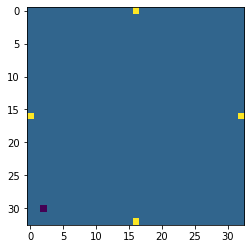

In [ ]:
env.render()

In [ ]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action, value = policy(states)
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])